In [1]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [13]:
import albumentations as A
import cv2
import random

transform_fn = A.Compose([
    A.HorizontalFlip(),
    A.Rotate(limit=20),
], additional_targets={'image1': 'image'})

In [148]:
class PairedDataset(Dataset):
    def __init__(self, a_dir, b_dir, split='train'):
        self.a_dir = a_dir
        self.b_dir = b_dir
        self.a_fps = os.listdir(a_dir)
        self.a_fps = [os.path.join(a_dir, x) for x in self.a_fps]
        self.b_fps = os.listdir(b_dir)
        self.b_fps = [os.path.join(b_dir, x) for x in self.b_fps]
        self.size = (256, 256)
        self.split = split
        
    def __getitem__(self, index):
        if self.split == 'train':
            a_fp = random.sample(self.a_fps, 1)[0]
        else:
            a_fp = self.a_fps[index]
        if self.split == 'train':
            b_fp = f"{a_fp.split('_')[0]}_A.jpg".replace("trainB", "trainA")
        else:
            b_fp = a_fp.replace(f"{self.split}B", f"{self.split}A")

        a_img = self._read(a_fp)
        b_img = self._read(b_fp)
        
        if self.split == 'train':
            result = transform_fn(image=a_img, image1=b_img)
            a_img = result['image']
            b_img = result['image1']
        a_img = self.get_input(a_img)
        b_img = self.get_input(b_img)
        a_img = torch.from_numpy(a_img).float()
        b_img = torch.from_numpy(b_img).float()
        return a_img, b_img
    
    def _read(self, fp):
        img = cv2.imread(fp)
        img = cv2.resize(img, self.size)
        return img
    
    def get_input(self, img):
        img = img / 255
        img = (img - 0.5) / 0.5
        img = np.transpose(img, (2, 0, 1))
        return img
    
    def __len__(self):
        return len(self.a_fps) * 10

In [67]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)
                      

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512,  1024),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(1024, 1, 4, padding=1, bias=False),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Sigmoid(),
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [179]:
def train_single_epoch(gen, disc, data_loader, b_size, epoch, 
                       l1_criterion, e_criterion,
                       optimizer_gen, optimizer_disc, lam=0.2):
    gen.train()
    disc.train()
    total_steps = len(data_loader)
    postfix_dict = {}
    tbar = tqdm(enumerate(data_loader), total=total_steps, position=0, leave=True)
    
    img_a, img_b = None, None
    
    for i, (img_a, img_b) in tbar:
        img_a = img_a.cuda()
        img_b = img_b.cuda()

        gen.zero_grad()
        disc.zero_grad()
        
        fake_b = gen(img_a)
        label = torch.full((b_size, 1, 1, 1), 0, dtype=torch.float, device='cuda')
        disc_fake = disc(img_a, fake_b)
        loss_disc_fake = e_criterion(disc_fake, label)
        loss_disc_fake.backward(retain_graph=True)
        
        label.fill_(1)
        disc_real = disc(img_a, img_b)
        loss_disc_real = e_criterion(disc_real, label)
        loss_disc_real.backward()
        postfix_dict["train/disc_loss"] = 0.5 * (loss_disc_fake + loss_disc_real).item()
        
        gen_loss = (1 - lam) * e_criterion(disc_fake, label) + lam * l1_criterion(img_b, fake_b)
        gen_loss.backward()
        postfix_dict["train/gen_loss"] = gen_loss.item()
        
        optimizer_gen.step()
        optimizer_disc.step()
        
        f_epoch = epoch + i / total_steps
        desc = '{:04d}/{:04d}, {:.2f} epoch'.format(i, total_steps, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)
    return gen_loss

def save_model(model, epoch, name):
    fp = os.path.join("../working/", name + '.pth')
    ckpt = {'state_dict': model.state_dict(),
            'epoch': epoch}
    torch.save(ckpt, fp)

def train(dir_a, dir_b, epochs, b_size=16):
    data = PairedDataset(dir_a, dir_b)
    data_loader = DataLoader(data, batch_size=b_size, num_workers=8, 
                              drop_last=True, shuffle=True)
    
    gen = GeneratorUNet().cuda()
    gen.load_state_dict(torch.load("../working/gen.pth")['state_dict'])
    disc = Discriminator().cuda()
    disc.load_state_dict(torch.load("../working/disc.pth")['state_dict'])
    
    e_criterion = nn.BCELoss()
    l1_criterion = nn.L1Loss()
    lr = 3e-4

    optimizer_gen = optim.Adam(gen.parameters(), lr=lr)
    optimizer_disc = optim.Adam(disc.parameters(), lr=lr)
    
    for epoch in range(epochs):
        train_single_epoch(gen, disc, data_loader, b_size, epoch, 
                           l1_criterion, e_criterion,
                           optimizer_gen, optimizer_disc)
        save_model(gen, epoch, "gen")
        save_model(disc, epoch, "disc")

In [180]:
x = train("/kaggle/input/facades-dataset/trainB/", 
          "/kaggle/input/facades-dataset/trainA/", 10)

0249/0250, 10.00 epoch: 100%|██████████| 250/250 [02:30<00:00,  1.66it/s, train/disc_loss=0.293, train/gen_loss=0.715]


In [181]:
# gen = GeneratorUNet()
gen.load_state_dict(torch.load("../working/gen.pth")['state_dict'])

<All keys matched successfully>

In [182]:
data = PairedDataset("/kaggle/input/facades-dataset/testB/", "/kaggle/input/facades-dataset/testA/", split='test')

In [183]:
imgs = []
for i in range(6):
    img_a, img_b = data[i]
    fake_b = gen(img_a[None])
    imgs.append(img_a.detach().cpu().numpy().transpose(1, 2, 0))
    imgs.append(fake_b[0].detach().cpu().numpy().transpose(1, 2, 0))
    imgs.append(img_b.detach().cpu().numpy().transpose(1, 2, 0))

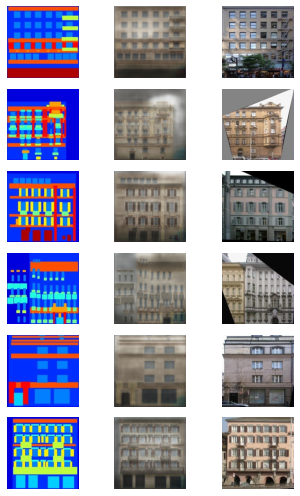

In [185]:
plt.figure(figsize=(5, 7))
for i in range(18):
    plt.subplot(6, 3, i+1)
    plt.imshow(0.5 + 0.5  * imgs[i][... , ::-1])
    plt.axis('off')
plt.tight_layout()